In [1]:
import numpy as np

# Interpolates a square heightmap using bicubic interpolation
# Methods:
#  - height(x, y) -> float            : returns the interpolated height at (x, y)
#  - gradient(x, y) -> [float, float] : returns the gradient of the interpolated height at (x, y)
# Height has continuous first derivatives; gradient is merely continuous
class HeightmapInterpolator:
    # From wikipedia: https://en.wikipedia.org/wiki/Bicubic_interpolation#Computation
    # The matrix product m * x * m^T where x =
    #     f(0, 0),  f(0, 1),  fy(0, 0),  fy(0, 1)
    #     f(0, 0),  f(0, 1),  fy(0, 0),  fy(0, 1)
    #     fx(0, 0), fx(0, 1), fxy(0, 0), fxy(0, 1)
    #     fx(0, 0), fx(0, 1), fxy(0, 0), fxy(0, 1)
    # gives the matrix of coefficients a which can be used to calculate p(x, y) by the following formula:
    # p(x, y) = [1 x x^2 x^3] * a * [1 y y^2 y^3]^T
    _m = np.array([
        [ 1, 0, 0, 0],
        [ 0, 0, 1, 0],
        [-3, 3,-2,-1],
        [ 2,-2, 1, 1]
    ])

    @staticmethod
    def _calc_interpolation_matrix(heightmap, x, y):
        def f(x, y): return heightmap[y][x]
        def fx(x, y): return 0.5 * (f(x + 1, y) - f(x - 1, y))
        def fy(x, y): return 0.5 * (f(x, y + 1) - f(x, y - 1))
        def fxy(x, y): return 0.25 * (f(x + 1, y + 1) + f(x - 1, y - 1) - f(x - 1, y + 1) - f(x + 1, y - 1))

        f00,   f01,   f10,   f11   = f(x, y),   f(x, y + 1),   f(x + 1, y),   f(x + 1, y + 1)
        f00x,  f01x,  f10x,  f11x  = fx(x, y),  fx(x, y + 1),  fx(x + 1, y),  fx(x + 1, y + 1)
        f00y,  f01y,  f10y,  f11y  = fy(x, y),  fy(x, y + 1),  fy(x + 1, y),  fy(x + 1, y + 1)
        f00xy, f01xy, f10xy, f11xy = fxy(x, y), fxy(x, y + 1), fxy(x + 1, y), fxy(x + 1, y + 1)

        M = np.array([
            [f00,  f01,  f00y,  f01y],
            [f10,  f11,  f10y,  f11y],
            [f00x, f01x, f00xy, f01xy],
            [f10x, f11x, f10xy, f11xy]
        ])
        return np.linalg.multi_dot((HeightmapInterpolator._m, M, HeightmapInterpolator._m.transpose()))

    def __init__(self, N, heightmap, bounds=None):
        # Extend the heightmap
        h_extended = [[None] * (N + 2), *[[None, *i, None] for i in heightmap], [None] * (N + 2)]
        for i in range(1, N + 1):
            h_extended[i][0] = 2 * h_extended[i][1] - h_extended[i][2]
            h_extended[i][-1] = 2 * h_extended[i][-2] - h_extended[i][-3]
        for i in range(N + 2):
            h_extended[0][i] = 2 * h_extended[1][i] - h_extended[2][i]
            h_extended[-1][i] = 2 * h_extended[-2][i] - h_extended[-3][i]

        self.heightmap = h_extended
        self.N = N
        self.bounds = (0, 0, N, N) if bounds is None else bounds

        # 2d array of 4x4 matrices
        self._height_interpolation = [[HeightmapInterpolator._calc_interpolation_matrix(h_extended, X, Y) for X in range(1, N)] for Y in range(1, N)]

    def _interpolation_matrix(self, X, Y):
        return self._height_interpolation[Y - 1][X - 1]

    def get_height(self, x, y):
        # Rescale x, y to fit bounds
        x -= self.bounds[0]
        y -= self.bounds[1]
        x *= self.N / (self.bounds[2] - self.bounds[0])
        y *= self.N / (self.bounds[3] - self.bounds[1])

        # Assume the height outside the heightmap is infinity
        if x < 0 or x >= self.N or y < 0 or y >= self.N:
            return float('inf')

        # X, Y = index of heightmap; t_x, t_y = proportion of the way to the next value
        X, tx = int(x), x % 1
        Y, ty = int(y), y % 1

        vx = np.array([1, tx, tx ** 2, tx ** 3])
        vy = np.array([1, ty, ty ** 2, ty ** 3])
        M = self._interpolation_matrix(X, Y)

        return np.linalg.multi_dot((vx, M, vy))

    def get_gradient(self, x, y):
        # Rescale x, y to fit bounds
        x -= self.bounds[0]
        y -= self.bounds[1]
        x *= (self.N - 3) / (self.bounds[2] - self.bounds[0])
        y *= (self.N - 3) / (self.bounds[3] - self.bounds[1])
        x += 1
        y += 1

        # out of bounds just returns a gradient of zero
        if x < 1 or x >= self.N - 2 or y < 1 or y >= self.N - 2:
            return np.array([0, 0])

        # X, Y = index of heightmap; t_x, t_y = proportion of the way to the next value
        X, tx = int(x), x % 1
        Y, ty = int(y), y % 1

        vx = np.array([1, tx, tx ** 2, tx ** 3])
        vy = np.array([1, ty, ty ** 2, ty ** 3])
        vx_ = np.array([0, 1, 2 * tx, 3 * tx ** 2])
        vy_ = np.array([0, 1, 2 * ty, 3 * ty ** 2])
        M = self._interpolation_matrix(X, Y)

        return np.array([np.linalg.multi_dot((vx_, M, vy)), np.linalg.multi_dot((vx, M, vy_))])

Equation of motion:
$$\frac{d^2\vec s}{dt^2} = -\nabla V - \beta \frac{d\vec s}{dt}$$
where $V(x, y)$ is the potential energy function and $\beta$ is a constant controlling the strength of the frictional force

generating heightmap
interpolating
simulating
plotting


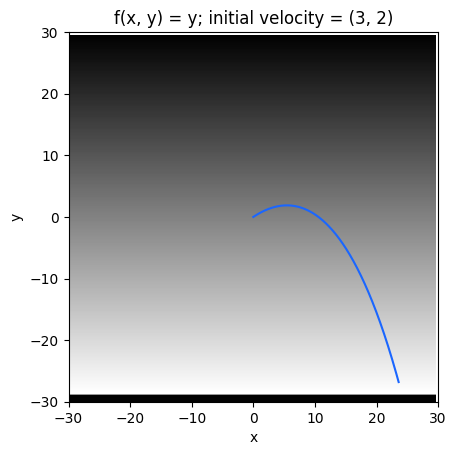

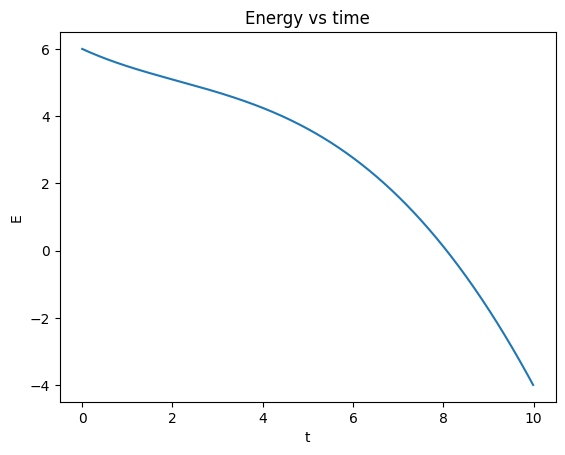

In [2]:
def distance_to_segment(P, A, B):
    AB = B - A
    AP = P - A
    l2 = np.dot(AB, AB)
    if l2 == 0: return np.dot(AP, AP)
    t = max(0, min(1, np.dot(AP, AB) / l2))
    Q = A + t * AB
    return np.sqrt(np.dot(P - Q, P - Q))

def check(h, title, beta=0):
    import matplotlib.pyplot as plt
    from scipy.integrate import odeint

    n = 30
    print('generating heightmap')
    heights = [[ h(x, y) for x in range(-n, n + 1)] for y in range(-n, n + 1)]
    print('interpolating')
    hMap = HeightmapInterpolator(2 * n + 1, heights, bounds=[-n, -n, n, n])

    print('simulating')
    def f(state, _):
        x, y, vx, vy = state

        gx, gy = hMap.get_gradient(x, y)

        ax = -gx - beta * vx
        ay = -gy - beta * vy
        return np.array([vx, vy, ax, ay])

    state0 = np.array([0, 0, 3, 2])
    t_vec = np.arange(0, 10, 0.01)
    states = odeint(f, state0, t_vec)
    x = states[:, 0]
    y = states[:, 1]
    vx = states[:, 2]
    vy = states[:, 3]
    KE = .5 * (vx * vx + vy * vy)
    PE = [hMap.get_height(x_, y_) for x_, y_ in zip(x, y)]
    E = KE + PE

    # print('Energy', E)

    print('plotting')
    hPoints = np.array([[hMap.get_height(x, y) for x in np.linspace(-n, n, 200)] for y in np.linspace(-n, n, 200)])
    plt.imshow(hPoints, cmap='binary', extent=[-n, n, n, -n])
    plt.plot(x, y, color=[.1, .4, 1])
    plt.xlim(-n, n)
    plt.ylim(-n, n)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(title + '; initial velocity = (3, 2)')
    plt.show()

    plt.title('Energy vs time')
    plt.xlabel('t')
    plt.ylabel('E')
    plt.plot(t_vec, E)
    plt.show()

import random

# check(lambda x, y : 0, 'f(x, y) = 0')
check(lambda x, y : y, 'f(x, y) = y', 0.05)
# check(lambda x, y : x + y, 'f(x, y) = x + y')
# check(lambda x, y : x * y, 'f(x, y) = xy')
# check(lambda x, y : random.random() * 10, 'f(x, y) = random()')
# def bump(x, y):
#     r2 = (x ** 2 + y ** 2) / 30
#     return - 5 * r2 / (1 + r2 ** 2)
# check(lambda x, y : bump(x - 4, y + 6) * 15, 'f(x, y) = bump(x, y)')